### O objetivo deste mini-projeto é aplicar técnicas de Machine Learning em Marketing Digital para prever a propabilidade de um lead ser convertido, ou seja, qual a probabilidade de um potencial cliente se tornar cliente e comprar o produto.

### Pergunta de negócio: Um lead será convertido? Sim ou Não? Qual probabilidade?

In [1]:
options(warn = -1)
# Carregando os pacotes necessários
library(caret) #auxilia no treinamento e avaliação de modelos de aprendizado de máquina
library(dplyr)
library(ggplot2)
library(readr)

Carregando pacotes exigidos: ggplot2

Carregando pacotes exigidos: lattice


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [2]:
df_md <- read_csv('dataset.csv')
head(df_md)

Rows: 1000 Columns: 7
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (5): faixa_etaria, cidade, cor_da_pele, navegador_web, converteu
dbl (2): numero_acessos, numero_cliques

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


numero_acessos,numero_cliques,faixa_etaria,cidade,cor_da_pele,navegador_web,converteu
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
65,57,18-24,Curitiba,negro,Edge,sim
99,38,55-64,Fortaleza,negro,Safari,sim
24,23,25-34,Curitiba,pardo,Chrome,sim
49,1,35-44,Curitiba,pardo,Edge,não
25,12,55-64,Natal,branco,Safari,não
1,1,45-54,Curitiba,negro,Safari,não


In [3]:
glimpse(df_md)

Rows: 1,000
Columns: 7
$ numero_acessos <dbl> 65, 99, 24, 49, 25, 1, 52, 81, 62, 2, 62, 73, 91, 32, 4…
$ numero_cliques <dbl> 57, 38, 23, 1, 12, 1, 42, 5, 57, 2, 60, 69, 42, 2, 37, …
$ faixa_etaria   <chr> "18-24", "55-64", "25-34", "35-44", "55-64", "45-54", "…
$ cidade         <chr> "Curitiba", "Fortaleza", "Curitiba", "Curitiba", "Natal…
$ cor_da_pele    <chr> "negro", "negro", "pardo", "pardo", "branco", "negro", …
$ navegador_web  <chr> "Edge", "Safari", "Chrome", "Edge", "Safari", "Safari",…
$ converteu      <chr> "sim", "sim", "sim", "não", "não", "não", "sim", "não",…


No contexto dos dados fornecidos, a cor da pele está sendo usada como uma variável categórica para descrever os clientes. No entanto, é fundamental lembrar que usar a cor da pele como um fator para prever a efetividade de um cliente pode ser eticamente questionável, discriminatória e, em muitos casos, é ilegal. **A inclusão de características discriminatórias pode levar a resultados enviesados e injustos, e pode reforçar estereótipos prejudiciais.**
- **Em muitas situações, é aconselhável remover variáveis que são diretamente relacionadas a características protegidas, como raça ou cor, para garantir que o modelo seja justo e não promova discriminação.**
- **A Lei Geral de Proteção de Dados Pessoais (LGPD)** também deixa claro que as atividades de tratamento de dados pessoais devem ser pautadas no princípio da  não discriminação.

A idade  também pode ser considerada uma variável sensível e potencialmente discriminatória em certos contextos, especialmente se for usada de maneira inadequada ou injusta. **A utilização de faixas etárias em vez de idades específicas é uma abordagem comum para mitigar preocupações sobre discriminação etária.**
- **Assim, é altamente recomendável converter a variável 'idade' em faixas etárias.**

In [4]:
# Remove a variável
df_md$cor_da_pele <- NULL

In [5]:
head(df_md)

numero_acessos,numero_cliques,faixa_etaria,cidade,navegador_web,converteu
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
65,57,18-24,Curitiba,Edge,sim
99,38,55-64,Fortaleza,Safari,sim
24,23,25-34,Curitiba,Chrome,sim
49,1,35-44,Curitiba,Edge,não
25,12,55-64,Natal,Safari,não
1,1,45-54,Curitiba,Safari,não


## Análise Exploratória 

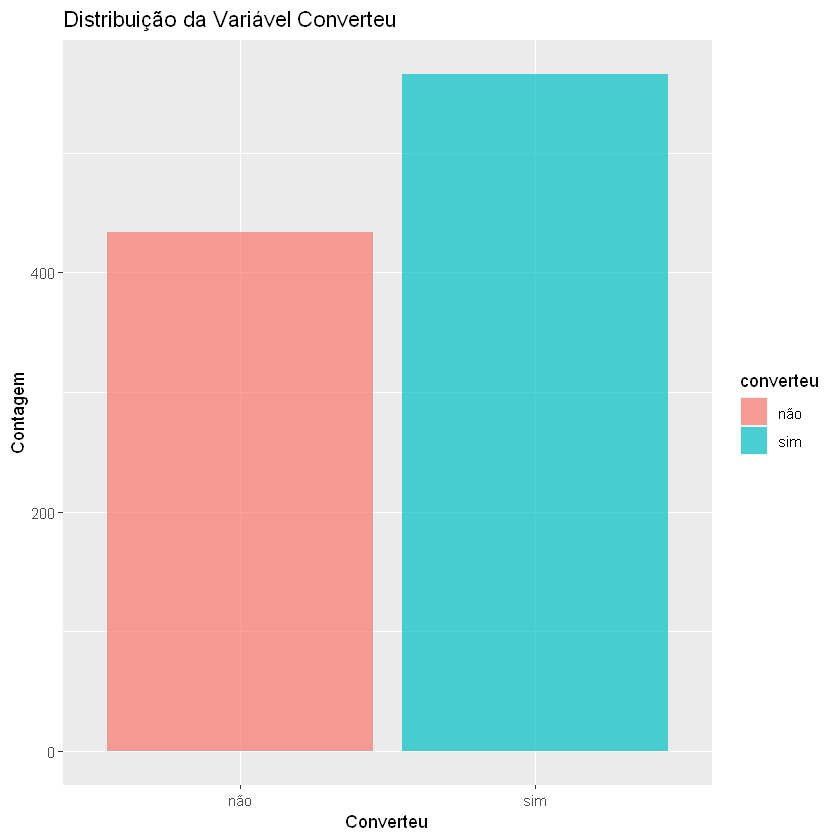

In [6]:
ggplot(df_md, aes(x=converteu)) + 
  geom_bar(aes(fill=converteu), alpha=0.7) +
  ggtitle('Distribuição da Variável Converteu') +
  xlab("Converteu") +
  ylab("Contagem")

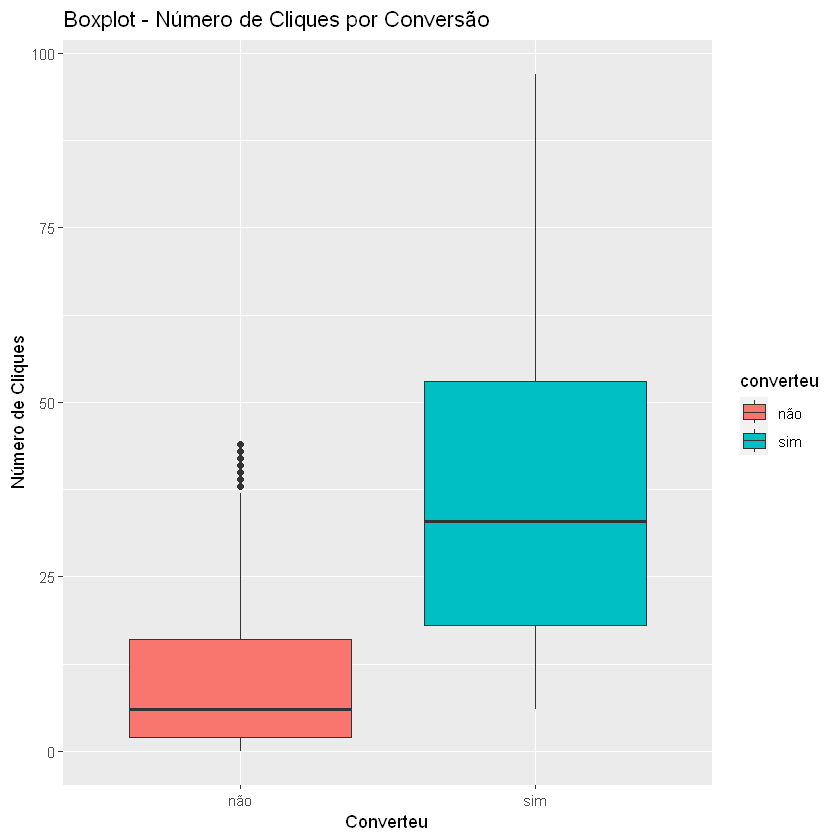

In [7]:
# Boxplot
ggplot(df_md, aes(x=converteu, y=numero_cliques, fill=converteu)) + 
  geom_boxplot() +
  ggtitle("Boxplot - Número de Cliques por Conversão") + 
  xlab("Converteu") + 
  ylab("Número de Cliques")

Pelo **diagrama de caixa** é possível perceber que a mediana do número de cliques dos clientes que converteram e não converteram segue um padrão esperado. Clientes que tiveram menos cliques (uma mediana menor) foram os que menos converteram. Já os clientes que tiveram uma mediana maior para o número de cliques foram os que mais converteram. 

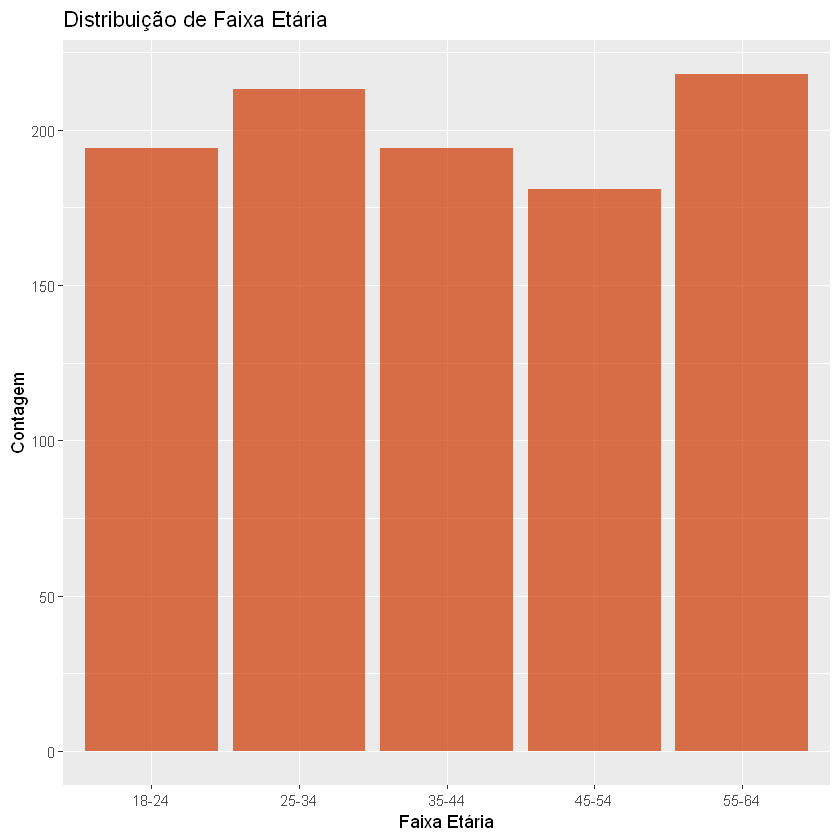

In [8]:
# Gráfico de barras
ggplot(df_md, aes(x=faixa_etaria)) + 
  geom_bar(fill="orangered3", alpha=0.7) +
  ggtitle("Distribuição de Faixa Etária") + 
  xlab("Faixa Etária") + 
  ylab("Contagem")

`geom_smooth()` using formula = 'y ~ x'


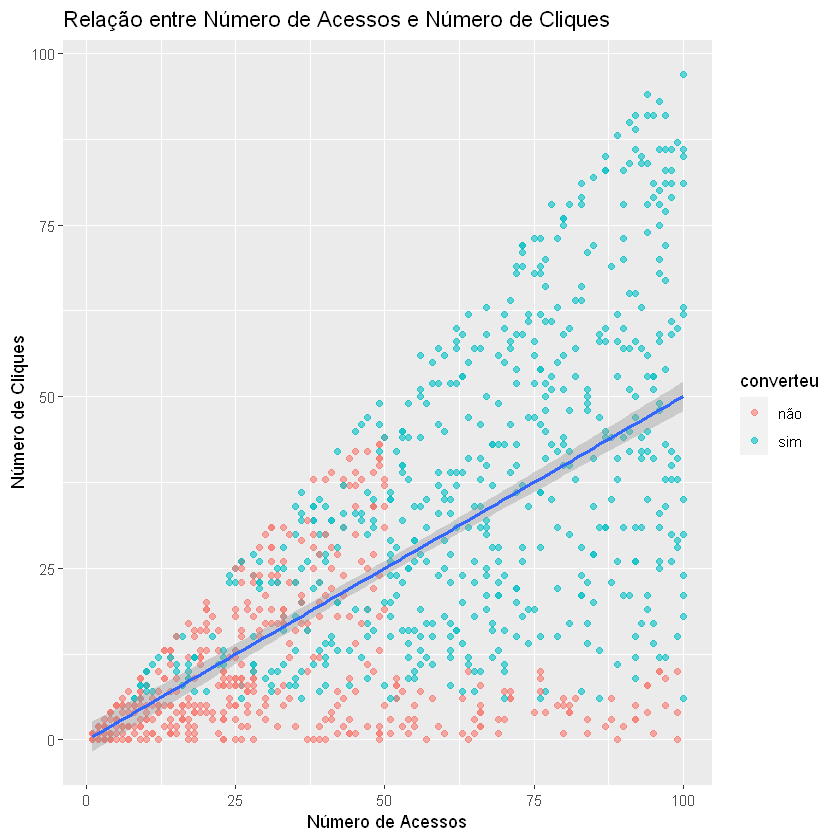

In [9]:
# Gráfico de dispersão
ggplot(df_md, aes(x=numero_acessos, y=numero_cliques)) + 
  geom_point(aes(color=converteu), alpha=0.6) + 
  geom_smooth(method='lm') + #Cria linha de regressão
  ggtitle("Relação entre Número de Acessos e Número de Cliques") +
  xlab("Número de Acessos") + 
  ylab("Número de Cliques")

Conforme verificado no gráfico de dispersão, o número de acessos e o número de cliques está relacionado com o número de clientes que converteu.

In [10]:
# Sumarizar dados para obter a média do número de acessos por cidade
dados_sumarizados <- aggregate(numero_acessos ~ cidade, data = df_md, FUN = mean)
dados_sumarizados

cidade,numero_acessos
<chr>,<dbl>
Blumenau,51.36082
Curitiba,49.68246
Fortaleza,51.89091
Natal,53.04737
Salvador,48.87568


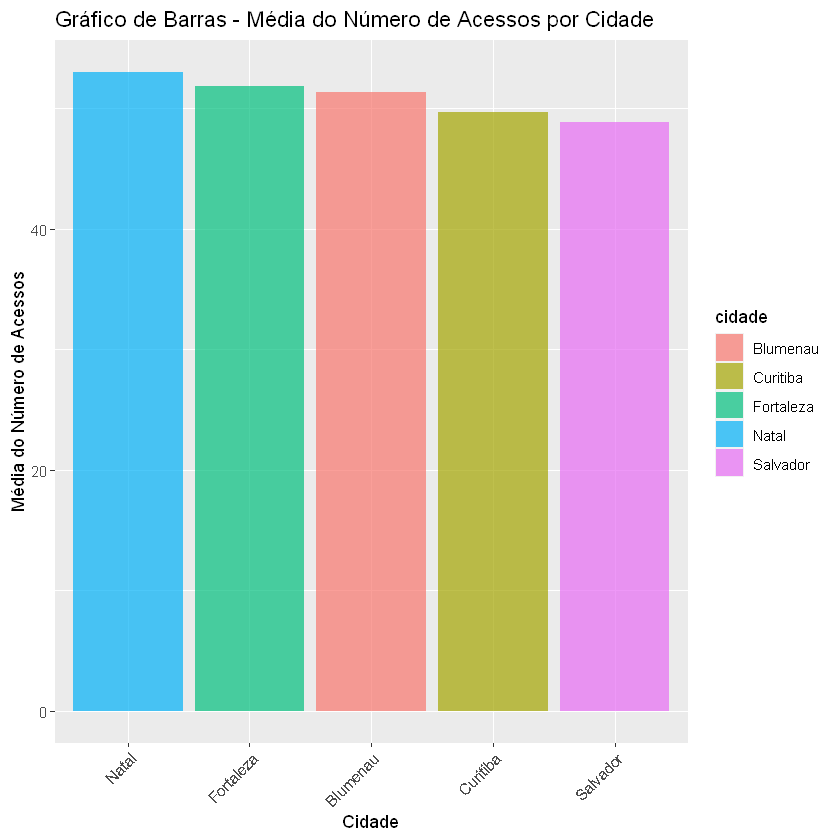

In [11]:
# Gráfico de barras
ggplot(dados_sumarizados, aes(x=reorder(cidade, -numero_acessos), y=numero_acessos)) +
  geom_bar(stat="identity", aes(fill=cidade), alpha=0.7) +
  ggtitle("Gráfico de Barras - Média do Número de Acessos por Cidade") +
  xlab("Cidade") +
  ylab("Média do Número de Acessos") +
  theme(axis.text.x = element_text(angle=45, hjust=1))

### Encoding de variáveis categóricas

Algoritmos de machine learning são projetados para lidar com dados numéricos, frequentemente dependem de operações matemáticas, e trabalham melhor com dados numéricos do que com dados categóricos. Desta forma, há a necessidade de fazer encoding em variáveis categóricas.

O **encoding de variáveis categóricas** é o processo de converter variáveis categóricas, que representam diferentes categorias ou grupos, em um formato numérico para que possam ser facilmente utilizadas em algoritmos de aprendizado de máquina ou análises estatísticas

In [12]:
# Dividindo os dados em treino e teste
set.seed(42)  # para reprodutibilidade

#funçãocreateDataPartition é usada para dividir O conjunto de dados em partições para treinamento e teste
indices <- createDataPartition(df_md$converteu, p = 0.75, list = FALSE)
#ndica que 75% dos dados serão alocados para o conjunto de treinamento, e o restante (25%) será para o conjunto de teste.
treino <- df_md[indices,] #treino
teste <- df_md[-indices,] # operador -  exclui as observações correspondentes ao treino

In [13]:
head(treino)

numero_acessos,numero_cliques,faixa_etaria,cidade,navegador_web,converteu
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
65,57,18-24,Curitiba,Edge,sim
24,23,25-34,Curitiba,Chrome,sim
49,1,35-44,Curitiba,Edge,não
25,12,55-64,Natal,Safari,não
1,1,45-54,Curitiba,Safari,não
52,42,45-54,Fortaleza,Safari,sim


In [14]:
glimpse(treino)
glimpse(teste)

Rows: 751
Columns: 6
$ numero_acessos <dbl> 65, 24, 49, 25, 1, 52, 81, 2, 73, 91, 32, 94, 61, 100, …
$ numero_cliques <dbl> 57, 23, 1, 12, 1, 42, 5, 2, 69, 42, 2, 21, 52, 18, 32, …
$ faixa_etaria   <chr> "18-24", "25-34", "35-44", "55-64", "45-54", "45-54", "…
$ cidade         <chr> "Curitiba", "Curitiba", "Curitiba", "Natal", "Curitiba"…
$ navegador_web  <chr> "Edge", "Chrome", "Edge", "Safari", "Safari", "Safari",…
$ converteu      <chr> "sim", "sim", "não", "não", "não", "sim", "não", "não",…
Rows: 249
Columns: 6
$ numero_acessos <dbl> 99, 62, 62, 44, 4, 68, 66, 10, 81, 29, 28, 38, 70, 55, …
$ numero_cliques <dbl> 38, 57, 60, 37, 4, 43, 4, 3, 4, 19, 0, 28, 60, 3, 51, 8…
$ faixa_etaria   <chr> "55-64", "35-44", "25-34", "18-24", "45-54", "55-64", "…
$ cidade         <chr> "Fortaleza", "Natal", "Blumenau", "Blumenau", "Curitiba…
$ navegador_web  <chr> "Safari", "Edge", "Edge", "Edge", "Chrome", "Edge", "Sa…
$ converteu      <chr> "sim", "sim", "sim", "não", "não", "sim", "não", "não",

In [15]:
# Aplicando label encoding à variável alvo
treino$converteu <- as.factor(treino$converteu)
teste$converteu <- as.factor(teste$converteu)

In [16]:
#Variável convertida para o tipo fator
str(treino)
str(teste)

tibble [751 × 6] (S3: tbl_df/tbl/data.frame)
 $ numero_acessos: num [1:751] 65 24 49 25 1 52 81 2 73 91 ...
 $ numero_cliques: num [1:751] 57 23 1 12 1 42 5 2 69 42 ...
 $ faixa_etaria  : chr [1:751] "18-24" "25-34" "35-44" "55-64" ...
 $ cidade        : chr [1:751] "Curitiba" "Curitiba" "Curitiba" "Natal" ...
 $ navegador_web : chr [1:751] "Edge" "Chrome" "Edge" "Safari" ...
 $ converteu     : Factor w/ 2 levels "não","sim": 2 2 1 1 1 2 1 1 2 2 ...
tibble [249 × 6] (S3: tbl_df/tbl/data.frame)
 $ numero_acessos: num [1:249] 99 62 62 44 4 68 66 10 81 29 ...
 $ numero_cliques: num [1:249] 38 57 60 37 4 43 4 3 4 19 ...
 $ faixa_etaria  : chr [1:249] "55-64" "35-44" "25-34" "18-24" ...
 $ cidade        : chr [1:249] "Fortaleza" "Natal" "Blumenau" "Blumenau" ...
 $ navegador_web : chr [1:249] "Safari" "Edge" "Edge" "Edge" ...
 $ converteu     : Factor w/ 2 levels "não","sim": 2 2 2 1 1 2 1 1 1 1 ...


In [17]:
# Aplicando label encoding às variáveis categóricas
treino$faixa_etaria <- as.factor(treino$faixa_etaria)
treino$cidade <- as.factor(treino$cidade)
treino$navegador_web <- as.factor(treino$navegador_web)

In [18]:
head(treino)

numero_acessos,numero_cliques,faixa_etaria,cidade,navegador_web,converteu
<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>
65,57,18-24,Curitiba,Edge,sim
24,23,25-34,Curitiba,Chrome,sim
49,1,35-44,Curitiba,Edge,não
25,12,55-64,Natal,Safari,não
1,1,45-54,Curitiba,Safari,não
52,42,45-54,Fortaleza,Safari,sim


In [19]:
teste$faixa_etaria <- as.factor(teste$faixa_etaria)
teste$cidade <- as.factor(teste$cidade)
teste$navegador_web <- as.factor(teste$navegador_web)

In [20]:
head(teste)

numero_acessos,numero_cliques,faixa_etaria,cidade,navegador_web,converteu
<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>
99,38,55-64,Fortaleza,Safari,sim
62,57,35-44,Natal,Edge,sim
62,60,25-34,Blumenau,Edge,sim
44,37,18-24,Blumenau,Edge,não
4,4,45-54,Curitiba,Chrome,não
68,43,55-64,Natal,Edge,sim


## Modelagem Preditiva
### Treinando o modelo de regressão logística

 - A regressão logística é um método estatístico utilizado para modelar a probabilidade de ocorrência de um evento binário. Este método é comumente utilizado em problemas nos quais a variável dependente é binária, ou seja, tem apenas dois possíveis resultados, como sim/não, sucesso/fracasso, 1/0, etc.
 - Ao contrário da regressão linear, que é usada para prever valores contínuos, a regressão logística usa a função logística para transformar a combinação linear das variáveis independentes em uma probabilidade entre 0 e 1. Ela é particularmente útil quando a variável dependente é categórica e binária, e o objetivo é entender a relação entre as variáveis independentes e a probabilidade de o evento ocorrer.

In [21]:
# Versão 1 do modelo
# . sinaliza que estou usando todas as variáveis preditoras: numero_acessos, numero_cliques, faixa_etaria, cidade e navegador.
modelo_v1 <- glm(converteu ~ ., family = binomial(link = 'logit'), data = treino)

**family:** Este argumento especifica a distribuição da família a ser usada no modelo. Em um modelo de regressão logística, você está lidando com uma variável de resposta binária (duas categorias), então a distribuição binomial é apropriada.  
**binomial:** Este é o tipo de distribuição usado para modelar variáveis binárias.  
**link:** Este argumento especifica a função de ligação utilizada para relacionar a média da distribuição à combinação linear das variáveis independentes.
**A função de ligação logística ('logit')** é comumente usada em regressão logística. A função logística transforma valores lineares em uma escala entre 0 e 1, o que é crucial para interpretar os resultados como probabilidades.

In [22]:
summary(modelo_v1)


Call:
glm(formula = converteu ~ ., family = binomial(link = "logit"), 
    data = treino)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.74429  -0.24418   0.00572   0.20703   2.26234  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -8.15188    0.86818  -9.390  < 2e-16 ***
numero_acessos        0.06397    0.00720   8.884  < 2e-16 ***
numero_cliques        0.16320    0.01645   9.918  < 2e-16 ***
faixa_etaria25-34     4.95394    0.61002   8.121 4.62e-16 ***
faixa_etaria35-44     5.26812    0.64366   8.185 2.73e-16 ***
faixa_etaria45-54     0.62731    0.48849   1.284    0.199    
faixa_etaria55-64    -0.09947    0.46198  -0.215    0.830    
cidadeCuritiba       -0.51948    0.46393  -1.120    0.263    
cidadeFortaleza      -0.35657    0.42570  -0.838    0.402    
cidadeNatal          -0.01710    0.44780  -0.038    0.970    
cidadeSalvador        0.53860    0.43424   1.240    0.215    
navegador_webEdge     0.59

In [23]:
# Fazendo previsões no conjunto de teste
previsoes_prob <- predict(modelo_v1, newdata = teste, type = 'response')
print(previsoes_prob)

           1            2            3            4            5            6 
0.9895393840 0.9999826743 0.9999857085 0.7853065793 0.0007957925 0.9757474649 
           7            8            9           10           11           12 
0.0646953770 0.0013811082 0.1425759663 0.0680292200 0.1463562774 0.4777275031 
          13           14           15           16           17           18 
0.9968627742 0.6920638333 0.9975083419 0.5120543953 0.0926312783 0.9922344307 
          19           20           21           22           23           24 
0.1452754751 0.3621397488 0.9883419381 0.1515762525 0.0031659049 0.9755170272 
          25           26           27           28           29           30 
0.0010412410 0.6720705559 0.6104905363 0.9999129809 0.0024151949 0.0042519272 
          31           32           33           34           35           36 
0.2110585452 0.0104558576 0.0026513553 0.8735032796 0.9898400670 0.9999982194 
          37           38           39           40 

**type = 'response':** Este argumento especifica o tipo de previsões desejado. No contexto de uma regressão logística, 'response' significa que você está interessado nas probabilidades previstas.

In [24]:
previsoes_classe <- ifelse(previsoes_prob > 0.5, 'sim', 'não') #cutoff
print(previsoes_classe)
#Se a probabilidade for maior que 0.5, a condição é verdadeira.

    1     2     3     4     5     6     7     8     9    10    11    12    13 
"sim" "sim" "sim" "sim" "não" "sim" "não" "não" "não" "não" "não" "não" "sim" 
   14    15    16    17    18    19    20    21    22    23    24    25    26 
"sim" "sim" "sim" "não" "sim" "não" "não" "sim" "não" "não" "sim" "não" "sim" 
   27    28    29    30    31    32    33    34    35    36    37    38    39 
"sim" "sim" "não" "não" "não" "não" "não" "sim" "sim" "sim" "não" "sim" "não" 
   40    41    42    43    44    45    46    47    48    49    50    51    52 
"sim" "não" "não" "sim" "sim" "sim" "não" "não" "sim" "sim" "sim" "sim" "não" 
   53    54    55    56    57    58    59    60    61    62    63    64    65 
"sim" "sim" "não" "não" "sim" "sim" "sim" "não" "não" "não" "não" "sim" "não" 
   66    67    68    69    70    71    72    73    74    75    76    77    78 
"sim" "não" "sim" "sim" "não" "não" "não" "sim" "sim" "sim" "não" "sim" "sim" 
   79    80    81    82    83    84    85    86    8

**A matriz de confusão** compara as previsões feitas pelo modelo com os valores reais. 

In [25]:
# Matriz de confusão
matriz_confusao <- confusionMatrix(as.factor(previsoes_classe), teste$converteu)
print(matriz_confusao)

Confusion Matrix and Statistics

          Reference
Prediction não sim
       não  93  11
       sim  15 130
                                          
               Accuracy : 0.8956          
                 95% CI : (0.8508, 0.9306)
    No Information Rate : 0.5663          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.7865          
                                          
 Mcnemar's Test P-Value : 0.5563          
                                          
            Sensitivity : 0.8611          
            Specificity : 0.9220          
         Pos Pred Value : 0.8942          
         Neg Pred Value : 0.8966          
             Prevalence : 0.4337          
         Detection Rate : 0.3735          
   Detection Prevalence : 0.4177          
      Balanced Accuracy : 0.8915          
                                          
       'Positive' Class : não             
                              

No Generalized Linear Model (GLM) para regressão logística em R, a referência da categoria (ou classe "positiva") é definida com base nos níveis do fator da variável resposta. A primeira categoria (ou nível) da variável fator é usada como referência por padrão. No entanto, é possível reordenar os níveis do fator para definir qual classe deve ser tratada como a "positiva" ou referência.  
- treino$converteu <- relevel(treino$converteu, ref = "sim")  
- teste$converteu <- relevel(teste$converteu, ref = "sim")  
Essa classe "positiva" é apenas referência e não significa coisa boa ou ruim.

In [26]:
# Métricas de avaliação
acuracia <- sum(diag(matriz_confusao$table)) / sum(matriz_confusao$table)
cat("Acurácia:", acuracia, "\n")

Acurácia: 0.8955823 


Conforme verificamos anteriormente, **apenas duas faixas etárias apresentam significância estatística**, como não podemos remover somente duas faixas-etárias que não apresentaram bons resultados, pois isto tornaria o modelo tendencioso, optamos por remover completamente a varíavel faixa-etária.

In [27]:
# Versão 2 do modelo
modelo_v2 <- glm(converteu ~ numero_acessos + numero_cliques, family = binomial(link='logit'), data = treino)

In [28]:
# Sumário do modelo
summary(modelo_v2)


Call:
glm(formula = converteu ~ numero_acessos + numero_cliques, family = binomial(link = "logit"), 
    data = treino)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.34791  -0.62952   0.07993   0.58762   2.13941  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -3.027801   0.252469 -11.993  < 2e-16 ***
numero_acessos  0.030439   0.004280   7.112 1.14e-12 ***
numero_cliques  0.095377   0.009233  10.330  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1028.02  on 750  degrees of freedom
Residual deviance:  597.12  on 748  degrees of freedom
AIC: 603.12

Number of Fisher Scoring iterations: 6


In [29]:
# Fazendo previsões no conjunto de teste
previsoes_prob <- predict(modelo_v2, newdata = teste, type = 'response')
previsoes_classe <- ifelse(previsoes_prob > 0.5, 'sim', 'não')

In [30]:
# Matriz de confusão
matriz_confusao <- confusionMatrix(as.factor(previsoes_classe), teste$converteu)
matriz_confusao

Confusion Matrix and Statistics

          Reference
Prediction não sim
       não  84  26
       sim  24 115
                                         
               Accuracy : 0.7992         
                 95% CI : (0.744, 0.8471)
    No Information Rate : 0.5663         
    P-Value [Acc > NIR] : 8.204e-15      
                                         
                  Kappa : 0.5921         
                                         
 Mcnemar's Test P-Value : 0.8875         
                                         
            Sensitivity : 0.7778         
            Specificity : 0.8156         
         Pos Pred Value : 0.7636         
         Neg Pred Value : 0.8273         
             Prevalence : 0.4337         
         Detection Rate : 0.3373         
   Detection Prevalence : 0.4418         
      Balanced Accuracy : 0.7967         
                                         
       'Positive' Class : não            
                                         

In [31]:
# Métricas de avaliação
acuracia <- sum(diag(matriz_confusao$table)) / sum(matriz_confusao$table)
cat("Acurácia:", acuracia, "\n")

Acurácia: 0.7991968 


**Neste caso optamos por diminuir a acurácia do modelo para evitar um modelo tendencioso.**

### Deploy

In [32]:
# Salva o modelo treinado em disco
save(modelo_v2, file = "modelo_v2.RData")

In [33]:
# Carrega o modelo do disco
load("modelo_v2.RData")

In [34]:
# Novos dados
novos_dados <- data.frame(numero_acessos = c(60), numero_cliques = c(20))
novos_dados

numero_acessos,numero_cliques
<dbl>,<dbl>
60,20


In [35]:
# Previsões com novos dados
previsoes_novos_dados_prob <- predict(modelo_v2, newdata = novos_dados, type = 'response')
previsoes_novos_dados_classe <- ifelse(previsoes_novos_dados_prob > 0.5, 'sim', 'não')

In [36]:
# Mostrando as previsões de classe e probabilidade
novos_dados$Lead_Convertido <-previsoes_novos_dados_classe
novos_dados$Probabilidade <-previsoes_novos_dados_prob * 100
novos_dados

numero_acessos,numero_cliques,Lead_Convertido,Probabilidade
<dbl>,<dbl>,<chr>,<dbl>
60,20,sim,66.95277
